# Introduction

We are building a machine learning pipeline for classification of EEG signals.

Preprocessing files will be run separetely from this notebook, and we will import their variables.

This notebook will focus on creating the pipeline for assessing the best model to detect seizures in EEG signals. We will use three main strategies:

* Res2Net Transformer
* 1D-CNN + LSTM 
* Gated 2 Tower Transformer 

# Importing Packages

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import pickle
import copy

print(torch.cuda.is_available())
print(torch.__version__)


plt.style.use("ggplot")

True
2.0.0+cu118


# Importing and Preprocessing Data

In [2]:
%run ./preprocessing.py

In [3]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
y_test = torch.FloatTensor(y_test).unsqueeze(1)
y_val = torch.FloatTensor(y_val).unsqueeze(1)

In [4]:
y_train.unique(return_counts=True)

(tensor([0., 1.]), tensor([6440, 1610]))

In [10]:
class EEGDataset(Dataset):
    def __init__(self, features, target) -> None:
        super().__init__()
        self.features = features
        self.target = target

    def __getitem__(self, index):
        data = {}
        features = self.features[index]
        target = self.target[index]
        data["X"] = features
        data["y"] = target
        return data

    def __len__(self):
        return len(self.features)


BATCH_SIZE = 64
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
train_dataloader = DataLoader(EEGDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(EEGDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
final_train_dataloader = DataLoader(EEGDataset(torch.cat((X_train, X_val), 0), torch.cat((y_train, y_val), 0)), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(EEGDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# Creating Models

## Training code

In [63]:


def training(
        model, train_dataloader=None, val_dataloader=None,
        epochs=5, lr=0.001, device='cpu', earlystopping_tolerance=5):
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([9200/2300]).to(device))
    # criterion = nn.BCELoss()
    model_state = {
        "model": None,
        "train_loss": [],
        "val_loss": [],
    }
    best_validation = np.inf
    best_model = None
    count_tolerance = 0


    for epoch in range(epochs):
        training_loss = 0
        for i, data in enumerate(train_dataloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            X, y = data["X"].to(device), data["y"].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(X)
            train_loss = criterion(outputs, y)
            train_loss.backward()
            optimizer.step()

            # print statistics
            training_loss += train_loss.item()
        
        training_loss /= i
        
        if isinstance(val_dataloader, DataLoader):
            validation_loss = 0
            for j, data in enumerate(val_dataloader, 1):
                # get the inputs; data is a list of [inputs, labels]
                X, y = data["X"].to(device), data["y"].to(device)


                # forward + backward + optimize
                with torch.no_grad():
                    outputs = model(X)
                    val_loss = criterion(outputs, y)
                    # print statistics
                    validation_loss += val_loss.item()

            validation_loss /= j
            
            if (validation_loss) < best_validation:
                count_tolerance = 0
                best_validation = validation_loss
                best_model = copy.deepcopy(model)
            
            count_tolerance += 1
            print(f"Epoch: {epoch}\tTraining loss: {training_loss:.5f}\t\t Validation Loss: {validation_loss:.5f}")
            model_state["train_loss"].append(training_loss)
            model_state["val_loss"].append(validation_loss)

            if count_tolerance >= earlystopping_tolerance:
                break
            
        else:
            print(f"Epoch: {epoch}\tTraining loss: {training_loss:.5f}")
            model_state["train_loss"].append(training_loss)
            best_model = copy.deepcopy(model)
        
    
    model_state["model"] = best_model
    save_model(model_state)
    return model_state

def save_model(model_state):
    with open(f"models/{ model_state['model'].to_string() }.pkl", "wb") as fp:
        model_state["model"] = model_state["model"].to("cpu").state_dict()
        pickle.dump(model_state, fp)
        print("Saved model successfully!")

## 1D CNN-LSTM Model

In [65]:
class CNN_LSTM_Classifier(pl.LightningModule):
    def __init__(self,):
        super().__init__()
        self.device_ = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.conv_1 = nn.Conv1d(1, 64, 3)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool1d(2, 2)
        self.conv_layers = nn.Sequential(
            nn.Conv1d(64, 128, 3),
            nn.ReLU(),
            nn.Conv1d(128, 512, 3),
            nn.ReLU(),
            nn.Conv1d(512, 1024, 3),
            nn.ReLU()
        )
        self.flatten_layer = nn.Linear(82, 256)
        dropout = 0.2
        self.dropout = nn.Dropout(dropout)

        self.lstm = nn.LSTM(1024, 64, 2, batch_first=True, dropout=dropout)

        self.fc_out = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )


    def forward(self, X: torch.FloatTensor, y=None):
        X = X.transpose(1, 2)
        out = self.relu(self.conv_1(X))
        out = self.max_pool(out)
        out = self.conv_layers(out)
        out = self.flatten_layer(out)
        out = out.transpose(1, 2)
        out, (_, _) = self.lstm(out)
        out = out[:, -1, :]
        out = self.fc_out(out)
        return out
    
    def predict_batch(self, X: torch.FloatTensor):
        pred = (torch.sigmoid(self(X)) > 0.5).int()
        return pred

    def predict(self, dataloader: DataLoader):
        predictions = list()
        for i, data in enumerate(dataloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            with torch.no_grad():
                X = data["X"]
                y_pred = self.predict_batch(X)
                predictions.append(y_pred)
        predictions = torch.cat(predictions, 0)
        return predictions

    def to_string(self):
        return "CNN_LSTM_Classifier"


    
model = CNN_LSTM_Classifier()
state = training(model, train_dataloader, val_dataloader, device=DEVICE, epochs=25, lr=0.0001)
# state["model"]
# model.predict(test_dataloader).shape

Epoch: 0	Training loss: 1.10888		 Validation Loss: 1.10872
Epoch: 1	Training loss: 1.10554		 Validation Loss: 1.06402
Epoch: 2	Training loss: 0.83110		 Validation Loss: 0.86627
Epoch: 3	Training loss: 0.60076		 Validation Loss: 0.49241
Epoch: 4	Training loss: 0.50622		 Validation Loss: 0.39568
Epoch: 5	Training loss: 0.43333		 Validation Loss: 0.32331
Epoch: 6	Training loss: 0.37710		 Validation Loss: 0.29778
Epoch: 7	Training loss: 0.33673		 Validation Loss: 0.24449
Epoch: 8	Training loss: 0.29040		 Validation Loss: 0.27316
Epoch: 9	Training loss: 0.28996		 Validation Loss: 0.22532
Epoch: 10	Training loss: 0.24394		 Validation Loss: 0.24303
Epoch: 11	Training loss: 0.22964		 Validation Loss: 0.21420
Epoch: 12	Training loss: 0.22563		 Validation Loss: 0.25625
Epoch: 13	Training loss: 0.20938		 Validation Loss: 0.19447
Epoch: 14	Training loss: 0.20150		 Validation Loss: 0.20015
Epoch: 15	Training loss: 0.15896		 Validation Loss: 0.19160
Epoch: 16	Training loss: 0.15580		 Validation Loss

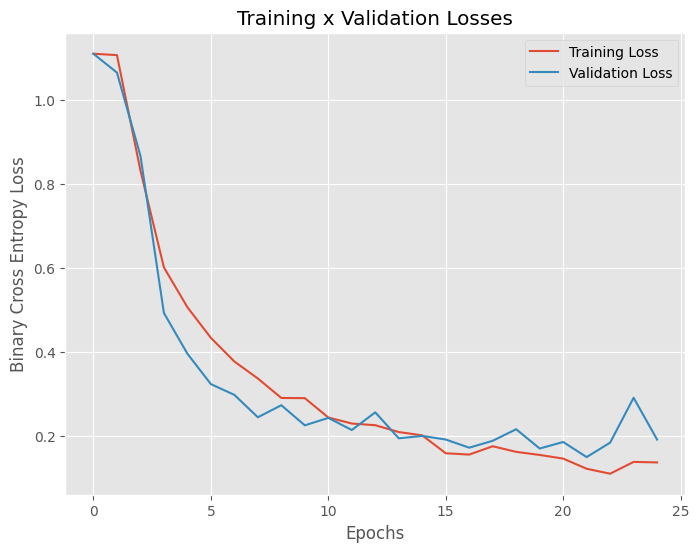

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(state["train_loss"], label="Training Loss")
plt.plot(state["val_loss"], label="Validation Loss")
plt.legend(loc="best")
plt.title("Training x Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.show()